# Part 1

In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Load main dataset
df = pd.read_csv("main.csv")
print(f"Total reviews: {len(df)}")
df.head(3)

Total reviews: 40000


,user,playtime,post_date,helpfulness,review_text,recommend,early_access_review,appid,game_name,release_date,genres
0,Pakistan warrior,47.8,"November 3, 2023",3911,ALT + F4 best feature in the game 10/10,True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action
1,Zuvi,1969.8,"November 2, 2022",3154,"SPAWN DIE, SPAWN DIE, SPAWN DIE, SPAWN DIE.-Jev",True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action
2,SƎXSƎN,1190.7,"August 5, 2023",2821,"My wife said if this review gets 100 likes, I ...",True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action


## Task 1.1 - Question 1

In [3]:
# Token length = number of tokens (whitespace-split words) per review
def token_length(text):
    if pd.isna(text):
        return 0
    return len(str(text).split())

df["token_length"] = df["review_text"].apply(token_length)
lengths = df["token_length"]

q25 = lengths.quantile(0.25)
q75 = lengths.quantile(0.75)
print(f"Q25 (25th percentile): {q25:.0f} tokens")
print(f"Q75 (75th percentile): {q75:.0f} tokens")

# Retain only Short (<= q25) or Long (>= q75)
short_mask = lengths <= q25
long_mask = lengths >= q75
df_task1 = df[short_mask | long_mask].copy()
df_task1["pseudo_label"] = np.where(df_task1["token_length"] <= q25, "Short", "Long")

n_retained = len(df_task1)
n_short = (df_task1["pseudo_label"] == "Short").sum()
n_long = (df_task1["pseudo_label"] == "Long").sum()
avg_short = df_task1.loc[df_task1["pseudo_label"] == "Short", "token_length"].mean()
avg_long = df_task1.loc[df_task1["pseudo_label"] == "Long", "token_length"].mean()

print("\n--- Question 1 Report ---")
print(f"Number of reviews retained: {n_retained} (Short: {n_short}, Long: {n_long})")
print(f"Average token length of Short reviews: {avg_short:.2f}")
print(f"Average token length of Long reviews:  {avg_long:.2f}")

Q25 (25th percentile): 11 tokens
Q75 (75th percentile): 179 tokens

--- Question 1 Report ---
Number of reviews retained: 20497 (Short: 10463, Long: 10034)
Average token length of Short reviews: 6.39
Average token length of Long reviews:  493.00


## Task 1.2 - Question 2


In [4]:
# TF-IDF on retained reviews (Task 1): unigrams, min_df=3, English stopwords
tfidf = TfidfVectorizer(ngram_range=(1, 1), min_df=3, stop_words="english")
X_tfidf = tfidf.fit_transform(df_task1["review_text"].fillna(""))

print("TF-IDF matrix:")
print(f"  Shape: {X_tfidf.shape} (samples × features)")
print(f"  Sparsity: {(1 - (X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1]))):.4%} zero entries")

TF-IDF matrix:
  Shape: (20497, 25085) (samples × features)
  Sparsity: 99.6763% zero entries


In [5]:
# MiniLM embeddings on retained reviews
from sentence_transformers import SentenceTransformer

encoder = SentenceTransformer("all-MiniLM-L6-v2")
texts = df_task1["review_text"].fillna("").tolist()
X_minilm = encoder.encode(texts)

print("MiniLM matrix:")
print(f"  Shape: {X_minilm.shape} (samples × dimensions)")
print(f"  Dense: no sparsity (all entries are non-zero floats)")

MiniLM matrix:
  Shape: (20497, 384) (samples × dimensions)
  Dense: no sparsity (all entries are non-zero floats)


In [6]:
# Question 2 Report: matrix dimensions
print("--- Question 2 Report ---")
print(f"TF-IDF: {X_tfidf.shape[0]} × {X_tfidf.shape[1]} (reviews × vocabulary)")
print(f"MiniLM: {X_minilm.shape[0]} × {X_minilm.shape[1]} (reviews × embedding dim)")


--- Question 2 Report ---
TF-IDF: 20497 × 25085 (reviews × vocabulary)
MiniLM: 20497 × 384 (reviews × embedding dim)


TF-IDF produces a sparse matrix because each review uses only a small subset of the vocabulary, so most entries are zero. MiniLM produces a dense matrix because every review is a fixed-length vector of 384 floats with (effectively) no zeros.

## Task 1.3 - Question 3

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score

# Install umap-learn and hdbscan in the notebook's Python if missing (fixes "No module named 'umap'")
try:
    import umap
    import hdbscan
except ModuleNotFoundError:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn", "hdbscan", "-q"])
    import umap
    import hdbscan

# Ground truth: Short=0, Long=1
y_true = (df_task1["pseudo_label"] == "Long").astype(int).values

# Precompute reduced representations (so we don't repeat slow steps)
# TF-IDF: raw (sparse), SVD(50), SVD(50)->UMAP(50)
svd_tfidf = TruncatedSVD(n_components=50, random_state=42)
X_tfidf_svd = svd_tfidf.fit_transform(X_tfidf)
X_tfidf_umap = umap.UMAP(n_components=50, random_state=42, metric="cosine").fit_transform(X_tfidf_svd)

# MiniLM: raw (dense), SVD(50), UMAP(50)
X_minilm_dense = np.asarray(X_minilm, dtype=np.float64)
svd_minilm = TruncatedSVD(n_components=50, random_state=42)
X_minilm_svd = svd_minilm.fit_transform(X_minilm_dense)
X_minilm_umap = umap.UMAP(n_components=50, random_state=42, metric="cosine").fit_transform(X_minilm_dense)

/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [8]:
def compute_metrics(y_true, y_pred):
    return {
        "homogeneity": homogeneity_score(y_true, y_pred),
        "completeness": completeness_score(y_true, y_pred),
        "v_measure": v_measure_score(y_true, y_pred),
        "ARI": adjusted_rand_score(y_true, y_pred),
        "AMI": adjusted_mutual_info_score(y_true, y_pred),
    }

# Pipelines to run: (representation, DR, X_input, run_agglo, run_hdbscan)
# TF-IDF + None: only K-Means (sparse); Agglomerative needs dense (infeasible); HDBSCAN typically needs dense
# TF-IDF + SVD: all three
# TF-IDF + UMAP: all three (already SVD then UMAP)
# MiniLM + None / SVD / UMAP: all three
pipelines = [
    ("TF-IDF", "None", X_tfidf, False, False),           # sparse: K-Means only
    ("TF-IDF", "SVD(50)", X_tfidf_svd, True, True),
    ("TF-IDF", "UMAP(50)", X_tfidf_umap, True, True),
    ("MiniLM", "None", X_minilm_dense, True, True),
    ("MiniLM", "SVD(50)", X_minilm_svd, True, True),
    ("MiniLM", "UMAP(50)", X_minilm_umap, True, True),
]

results = []
for rep, dr_name, X, do_agglo, do_hdb in pipelines:
    # K-Means accepts sparse; Agglomerative/HDBSCAN need dense (we skip them for TF-IDF+None to avoid huge dense matrix)
    km = KMeans(n_clusters=2, random_state=42, n_init=10)
    m = compute_metrics(y_true, km.fit_predict(X))  # X can be sparse for K-Means
    results.append({"Representation": rep, "DR": dr_name, "Clustering": "K-Means", **m})
    if do_agglo:
        X_dense = X.toarray() if hasattr(X, "toarray") else np.asarray(X)
        ac = AgglomerativeClustering(n_clusters=2)
        m = compute_metrics(y_true, ac.fit_predict(X_dense))
        results.append({"Representation": rep, "DR": dr_name, "Clustering": "Agglomerative", **m})
    else:
        results.append({"Representation": rep, "DR": dr_name, "Clustering": "Agglomerative", "homogeneity": None, "completeness": None, "v_measure": None, "ARI": None, "AMI": None, "skip_reason": "Agglomerative requires dense input; TF-IDF without DR is too large to convert."})
    if do_hdb:
        X_dense = X.toarray() if hasattr(X, "toarray") else np.asarray(X)
        hdb_model = hdbscan.HDBSCAN(min_cluster_size=2)
        m = compute_metrics(y_true, hdb_model.fit_predict(X_dense))
        results.append({"Representation": rep, "DR": dr_name, "Clustering": "HDBSCAN", **m})
    else:
        results.append({"Representation": rep, "DR": dr_name, "Clustering": "HDBSCAN", "homogeneity": None, "completeness": None, "v_measure": None, "ARI": None, "AMI": None, "skip_reason": "HDBSCAN requires dense input; TF-IDF without DR is too large to convert."})

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/anaconda3/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...


In [9]:
# Build table (only rows with numeric metrics)
df_results = pd.DataFrame(results)
# Add skip_reason column if missing
if "skip_reason" not in df_results.columns:
    df_results["skip_reason"] = None
df_metrics = df_results[df_results["v_measure"].notna()].copy()
df_skipped = df_results[df_results["v_measure"].isna() & df_results["skip_reason"].notna()]

print("--- Question 3 Report ---\n")
print("Skipped pipelines (TF-IDF + None):")
print(df_skipped[["Representation", "DR", "Clustering", "skip_reason"]].to_string(index=False))
display_cols = ["Representation", "DR", "Clustering", "homogeneity", "completeness", "v_measure", "ARI", "AMI"]
print("\nClustering agreement metrics (with ground-truth length labels):")
print(df_metrics[display_cols].round(4).to_string(index=False))

--- Question 3 Report ---

Skipped pipelines (TF-IDF + None):
Representation   DR    Clustering                                                                    skip_reason
        TF-IDF None Agglomerative Agglomerative requires dense input; TF-IDF without DR is too large to convert.
        TF-IDF None       HDBSCAN       HDBSCAN requires dense input; TF-IDF without DR is too large to convert.

Clustering agreement metrics (with ground-truth length labels):
Representation       DR    Clustering  homogeneity  completeness  v_measure    ARI    AMI
        TF-IDF     None       K-Means       0.6233        0.6248     0.6240 0.7274 0.6240
        TF-IDF  SVD(50)       K-Means       0.0301        0.1607     0.0507 0.0057 0.0507
        TF-IDF  SVD(50) Agglomerative       0.0276        0.1575     0.0470 0.0050 0.0470
        TF-IDF  SVD(50)       HDBSCAN       0.3488        0.0871     0.1393 0.0538 0.1205
        TF-IDF UMAP(50)       K-Means       0.3079        0.3139     0.3109 0.3744 0

In [10]:
# Summary table and best pipeline
summary = df_metrics[display_cols].round(4)
summary

,Representation,DR,Clustering,homogeneity,completeness,v_measure,ARI,AMI
0,TF-IDF,None,K-Means,0.6233,0.6248,0.6240,0.7274,0.6240
3,TF-IDF,SVD(50),K-Means,0.0301,0.1607,0.0507,0.0057,0.0507
4,TF-IDF,SVD(50),Agglomerative,0.0276,0.1575,0.0470,0.0050,0.0470
5,TF-IDF,SVD(50),HDBSCAN,0.3488,0.0871,0.1393,0.0538,0.1205
6,TF-IDF,UMAP(50),K-Means,0.3079,0.3139,0.3109,0.3744,0.3108
7,TF-IDF,UMAP(50),Agglomerative,0.2747,0.2830,0.2788,0.3296,0.2788
8,TF-IDF,UMAP(50),HDBSCAN,0.6558,0.0821,0.1459,0.0174,0.1284
9,MiniLM,None,K-Means,0.5089,0.5093,0.5091,0.6128,0.5091
10,MiniLM,None,Agglomerative,0.6603,0.6604,0.6603,0.7586,0.6603
11,MiniLM,None,HDBSCAN,0.3337,0.0779,0.1264,0.0002,0.1086


In [13]:
# Best-performing pipeline (by V-measure; tie-break by ARI)
best_idx = df_metrics.sort_values(["v_measure", "ARI"], ascending=[False, False]).index[0]
best = df_metrics.loc[best_idx]
print("Best-performing pipeline:")
print(f"  Representation: {best['Representation']}, DR: {best['DR']}, Clustering: {best['Clustering']}")
print(f"  Homogeneity: {best['homogeneity']:.4f}  Completeness: {best['completeness']:.4f}  V-measure: {best['v_measure']:.4f}  ARI: {best['ARI']:.4f}  AMI: {best['AMI']:.4f}")

Best-performing pipeline:
  Representation: MiniLM, DR: None, Clustering: Agglomerative
  Homogeneity: 0.6603  Completeness: 0.6604  V-measure: 0.6603  ARI: 0.7586  AMI: 0.6603


## Task 1.4 - Question 4

MiniLM had the best performing pipeline. 

This is because MiniLM encodes wording and style: short reviews are often formulaic ("great game", "10/10") while long reviews use more varied, elaborated language. That difference in style places them in different regions of the embedding space.

TF-IDF uses relative frequncy of words (which is normalized). It doesn't provide as much information as MiniLM to seperate long vs short. 

## Task 1.4 - Question 5

2D PCA visualization: best TF-IDF and best MiniLM configs. For each, one plot colored by ground-truth length label and one by cluster assignments.

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Best config per representation (by V-measure, tie-break ARI)
best_tfidf = df_metrics[df_metrics["Representation"] == "TF-IDF"].sort_values(["v_measure", "ARI"], ascending=[False, False]).iloc[0]
best_minilm = df_metrics[df_metrics["Representation"] == "MiniLM"].sort_values(["v_measure", "ARI"], ascending=[False, False]).iloc[0]

# Get X and cluster labels for best TF-IDF
dr_t, cl_t = best_tfidf["DR"], best_tfidf["Clustering"]
if dr_t == "None":
    X_t = X_tfidf
else:
    X_t = X_tfidf_svd if dr_t == "SVD(50)" else X_tfidf_umap
if cl_t == "K-Means":
    lab_t = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(X_t)
else:
    X_t_dense = X_t.toarray() if hasattr(X_t, "toarray") else np.asarray(X_t)
    lab_t = AgglomerativeClustering(n_clusters=2).fit_predict(X_t_dense)

# Get X and cluster labels for best MiniLM
dr_m, cl_m = best_minilm["DR"], best_minilm["Clustering"]
if dr_m == "None":
    X_m = X_minilm_dense
elif dr_m == "SVD(50)":
    X_m = X_minilm_svd
else:
    X_m = X_minilm_umap
if cl_m == "K-Means":
    lab_m = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(X_m)
else:
    lab_m = AgglomerativeClustering(n_clusters=2).fit_predict(X_m)

# 2D reduction for plotting: PCA (use TruncatedSVD for sparse TF-IDF as PCA equivalent)
if hasattr(X_t, "toarray"):
    reducer_t = TruncatedSVD(n_components=2, random_state=42)
    coords_t = reducer_t.fit_transform(X_t)
else:
    reducer_t = PCA(n_components=2, random_state=42)
    coords_t = reducer_t.fit_transform(X_t)
reducer_m = PCA(n_components=2, random_state=42)
coords_m = reducer_m.fit_transform(X_m)

# Ground-truth labels for coloring (Short=0, Long=1)
y_gt = y_true  # 0/1
gt_labels = np.array(["Short", "Long"])[y_gt]

# Align cluster labels so 0 ≈ Short, 1 ≈ Long (match ground-truth colors in the plot)
def align_clusters_to_ground_truth(lab, y_gt):
    if np.sum((lab == 0) & (y_gt == 1)) > np.sum((lab == 0) & (y_gt == 0)):
        return 1 - lab
    return lab
lab_t = align_clusters_to_ground_truth(lab_t, y_gt)
lab_m = align_clusters_to_ground_truth(lab_m, y_gt)

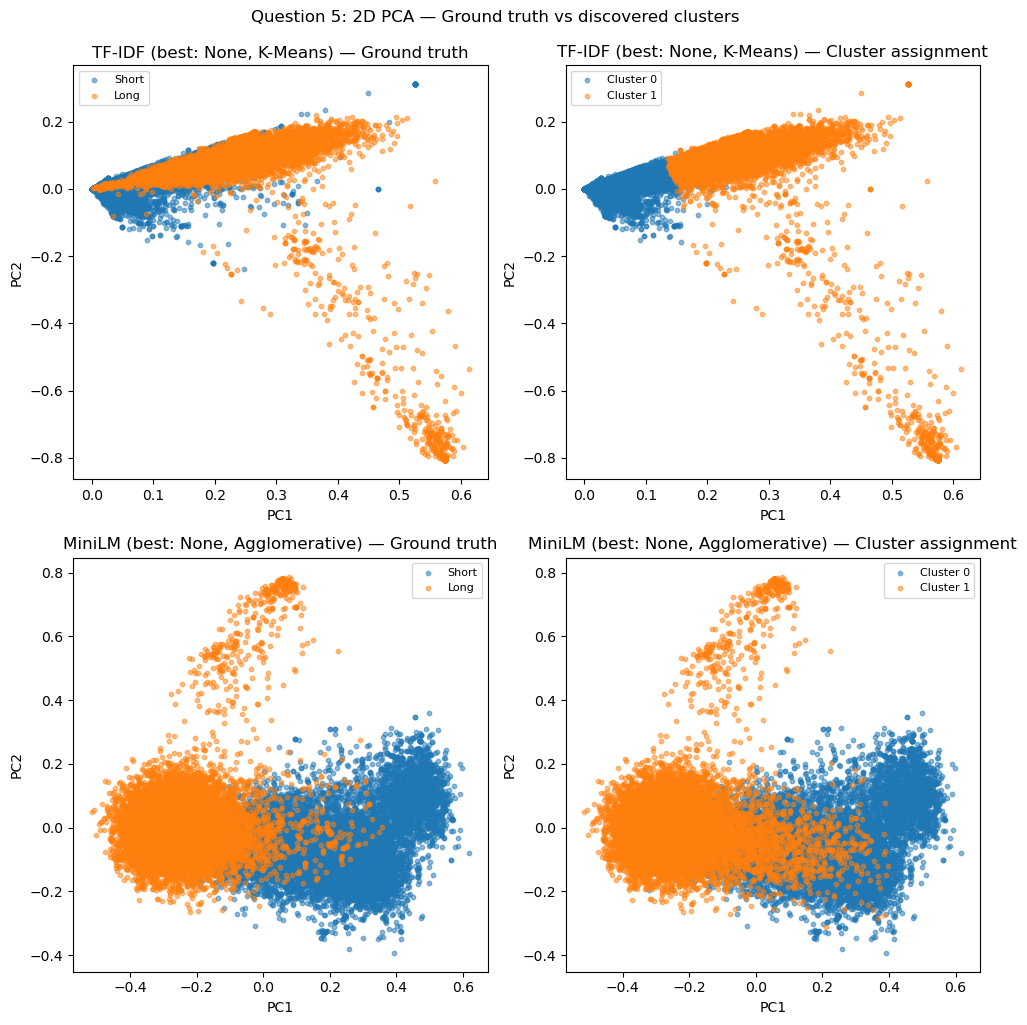

In [18]:
# Split visualization: ground truth vs cluster assignments (each representation)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Row 0: TF-IDF — ground truth | cluster assignment
ax0, ax1 = axes[0, 0], axes[0, 1]
for g in [0, 1]:
    mask = y_gt == g
    ax0.scatter(coords_t[mask, 0], coords_t[mask, 1], label=["Short", "Long"][g], alpha=0.5, s=10)
for k in [0, 1]:
    mask = lab_t == k
    ax1.scatter(coords_t[mask, 0], coords_t[mask, 1], label=f"Cluster {k}", alpha=0.5, s=10)
ax0.set_title(f"TF-IDF (best: {dr_t}, {cl_t}) — Ground truth")
ax1.set_title(f"TF-IDF (best: {dr_t}, {cl_t}) — Cluster assignment")
ax0.legend(loc="best", fontsize=8)
ax1.legend(loc="best", fontsize=8)

# Row 1: MiniLM — ground truth | cluster assignment
ax2, ax3 = axes[1, 0], axes[1, 1]
for g in [0, 1]:
    mask = y_gt == g
    ax2.scatter(coords_m[mask, 0], coords_m[mask, 1], label=["Short", "Long"][g], alpha=0.5, s=10)
for k in [0, 1]:
    mask = lab_m == k
    ax3.scatter(coords_m[mask, 0], coords_m[mask, 1], label=f"Cluster {k}", alpha=0.5, s=10)
ax2.set_title(f"MiniLM (best: {dr_m}, {cl_m}) — Ground truth")
ax3.set_title(f"MiniLM (best: {dr_m}, {cl_m}) — Cluster assignment")
ax2.legend(loc="best", fontsize=8)
ax3.legend(loc="best", fontsize=8)

for ax in axes.flat:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
plt.tight_layout()
plt.suptitle("Question 5: 2D PCA — Ground truth vs discovered clusters", y=1.02, fontsize=12)
plt.show()

## Task 2 - Unsupervised Game Similarity & Genre Structure

Cluster **games** by what players praise (positive reviews only).

---

### Task 2.1 - Question 6

Game-level representations (positive reviews only): TF-IDF = concatenate reviews per game then TF-IDF; MiniLM = average review embeddings per game. Report matrix dimensions.

In [ ]:
# Positive reviews only
from sentence_transformers import SentenceTransformer

df_pos = df[df["recommend"] == True].copy()
# One document per game: concatenate all positive review texts for that game
game_docs = df_pos.groupby("appid")["review_text"].apply(lambda s: " ".join(s.fillna("").astype(str))).reset_index()
game_ids = game_docs["appid"].values
game_names = df_pos.groupby("appid")["game_name"].first().reindex(game_docs["appid"]).values
texts_per_game = game_docs["review_text"].values

# TF-IDF game matrix: one row per game, columns = vocabulary (same settings: unigrams, min_df=3, English stopwords)
tfidf_game = TfidfVectorizer(ngram_range=(1, 1), min_df=3, stop_words="english")
X_tfidf_game = tfidf_game.fit_transform(texts_per_game)

# MiniLM game matrix: average review embeddings per game
encoder = SentenceTransformer("all-MiniLM-L6-v2")
all_reviews = df_pos["review_text"].fillna("").tolist()
all_appids = df_pos["appid"].values
review_embeddings = encoder.encode(all_reviews)
# Average per game (same order as game_ids)
X_minilm_game = np.array([
    review_embeddings[all_appids == gid].mean(axis=0)
    for gid in game_ids
])

print("Game-level representations (positive reviews only):")
print(f"  Number of games: {len(game_ids)}")
print(f"  TF-IDF game matrix shape: {X_tfidf_game.shape} (games × vocabulary)")
print(f"  MiniLM game matrix shape: {X_minilm_game.shape} (games × embedding dim)")

In [ ]:
# Question 6 Report
print("--- Question 6 Report ---")
print(f"TF-IDF game matrix: {X_tfidf_game.shape[0]} × {X_tfidf_game.shape[1]} (games × vocabulary)")
print(f"MiniLM game matrix: {X_minilm_game.shape[0]} × {X_minilm_game.shape[1]} (games × embedding dimension)")